<a href="https://colab.research.google.com/github/mandumonster/machinelearning/blob/main/%EA%B3%B5%EA%B5%B4%EB%A6%AC%EA%B8%B0%ED%8C%80%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader

In [ ]:
os.environ['KAGGLE_USERNAME']='mandumonster'
os.environ['KAGGLE_KEY']='3de2e52f56689fcb90b423b55f392a14'

In [ ]:
!kaggle datasets download -d samuelcortinhas/sports-balls-multiclass-image-classification

100% 401M/401M [00:19<00:00, 23.1MB/s]
100% 401M/401M [00:19<00:00, 22.1MB/s]


In [ ]:
! unzip -q /content/sports-balls-multiclass-image-classification.zip

In [ ]:
!mv test validation

# 학습시키기

In [ ]:
data_transforms={
    'train':transforms.Compose([
        transforms.Resize((224,224)),
        # 각도, 찌그러짐 정도 10, 크기
        transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [ ]:
image_datasets={
    'train':datasets.ImageFolder('train',data_transforms['train'], target_transform=target_transforms),
    'validation':datasets.ImageFolder('validation',data_transforms['validation'],target_transform=target_transforms)
}

In [ ]:
dataloaders={
    'train':DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation':DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [ ]:
print(len(image_datasets['train']),len(image_datasets['validation']))

7328 1841


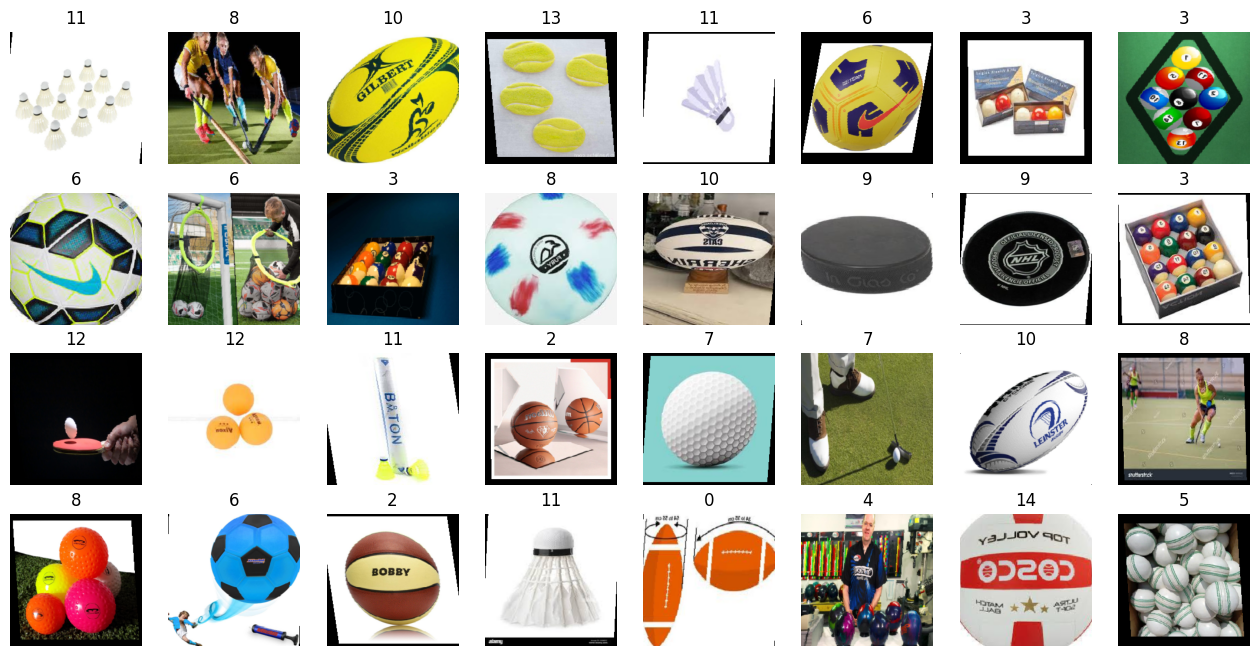

In [ ]:
imgs, labels=next(iter(dataloaders['train']))

fig, axes=plt.subplots(4,8,figsize=(16,8))

for ax, img, label in zip(axes.flatten(),imgs,labels):
  # print(img.shape)  #torch.Size([3, 224, 224]) 3은 color
  ax.imshow(img.permute(1,2,0)) # 순서 바꿔줌 [3[0], 224[1], 224[2]]->[224[1],224[2],3[0]]
  ax.set_title(label.item())
  ax.axis('off')

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [ ]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [ ]:
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
model = efficientnet_b4(weights="DEFAULT").to(device)

In [ ]:
for param in model.parameters():
  param.requires_grad=False # 가져온 파라미터 (W,b)를 업데이트하지 않음

model.classifier = nn.Sequential(
    nn.Linear(1792, 512),
    nn.ReLU(),
    nn.Linear(512,15)
).to(device)

In [ ]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            # print(y_batch.shape)    # torch.Size([32, 1])
            loss = nn.CrossEntropyLoss()(y_pred, y_batch.long().squeeze(dim=-1))
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)
            acc = (y_batch.long().squeeze(dim=-1) == y_pred_index).float().sum() / len(y_batch.long().squeeze(dim=-1)) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.6090, Accuracy: 80.98%
validation: Epoch    1/10, Loss: 0.6134, Accuracy: 80.07%
train     : Epoch    2/10, Loss: 0.5314, Accuracy: 83.24%
validation: Epoch    2/10, Loss: 0.5709, Accuracy: 82.78%
train     : Epoch    3/10, Loss: 0.4719, Accuracy: 84.70%
validation: Epoch    3/10, Loss: 0.5642, Accuracy: 82.83%
train     : Epoch    4/10, Loss: 0.4198, Accuracy: 86.84%
validation: Epoch    4/10, Loss: 0.5402, Accuracy: 83.58%
train     : Epoch    5/10, Loss: 0.4005, Accuracy: 87.13%
validation: Epoch    5/10, Loss: 0.5209, Accuracy: 83.59%
train     : Epoch    6/10, Loss: 0.3500, Accuracy: 88.35%
validation: Epoch    6/10, Loss: 0.5227, Accuracy: 84.22%
train     : Epoch    7/10, Loss: 0.3302, Accuracy: 88.84%
validation: Epoch    7/10, Loss: 0.5191, Accuracy: 84.71%
train     : Epoch    8/10, Loss: 0.3023, Accuracy: 90.38%
validation: Epoch    8/10, Loss: 0.5241, Accuracy: 84.01%
train     : Epoch    9/10, Loss: 0.2816, Accuracy: 90.67%
validation: Ep

In [ ]:
torch.save(model.state_dict(),'modelgong.pth')

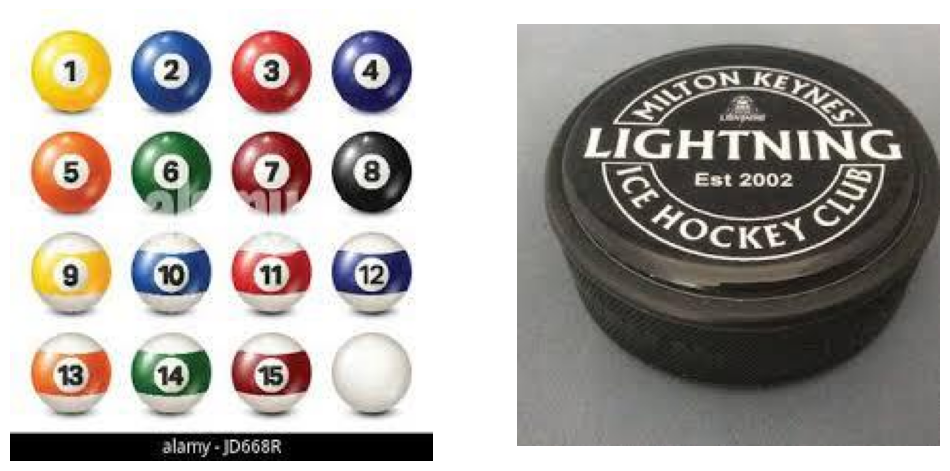

In [ ]:
from PIL import Image

img1=Image.open('/content/validation/billiard_ball/billiard_ball_1033.jpg')
img2=Image.open('/content/validation/hockey_puck/hockey_puck_195.jpg')

fig, axes=plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()


In [ ]:
img1_input=data_transforms['validation'](img1)
img2_input=data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
test_batch=torch.stack([img1_input,img2_input])
test_batch=test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
y_pred=model(test_batch)
y_pred

tensor([[-3.6407, -2.3446, -4.4582,  5.7362, -0.6840, -1.9628, -1.1635, -1.1920,
         -3.1060, -0.8198, -4.8676, -6.4451, -0.2414, -4.3212, -6.6938],
        [-9.4108, -2.5334, -2.0418, -4.4152, -3.4848, -0.2103, -2.7055, -6.7708,
         -2.4297,  8.3428, -1.4352, -7.5339, -5.9882, -8.3721, -4.4715]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
y_prob=nn.Softmax(1)(y_pred)

In [ ]:
probs, idx=torch.topk(y_prob, k=3)

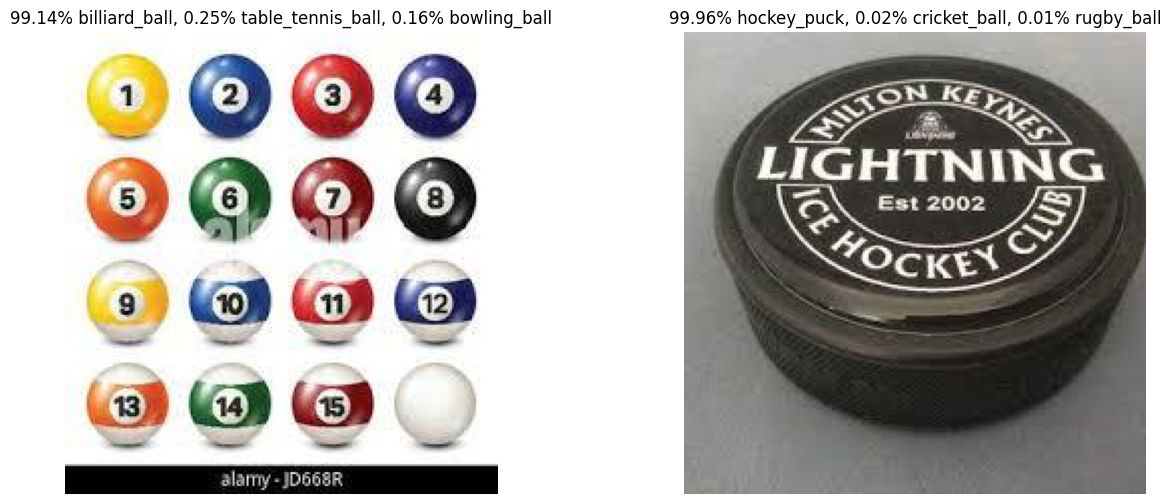

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(15,6))
axes[0].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[0,0]*100, image_datasets['validation'].classes[idx[0,0]],
    probs[0,1]*100, image_datasets['validation'].classes[idx[0,1]],
    probs[0,2]*100, image_datasets['validation'].classes[idx[0,2]]
))
axes[1].set_title('{:.2f}% {}, {:.2f}% {}, {:.2f}% {}'.format(
    probs[1,0]*100, image_datasets['validation'].classes[idx[1,0]],
    probs[1,1]*100, image_datasets['validation'].classes[idx[1,1]],
    probs[1,2]*100, image_datasets['validation'].classes[idx[1,2]]
))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [ ]:
# image_datasets={
#     'train':datasets.ImageFolder('train',data_transforms['train']),
#     'validation':datasets.ImageFolder('validation',data_transforms['validation'])
# }
# 이것때문에 오류났던듯? ㅜㅜ

In [ ]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            # print(y_batch.shape)    # torch.Size([32, 1])
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)
            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 5.8722, Accuracy: 6.17%
validation: Epoch    1/10, Loss: 3.2758, Accuracy: 20.51%
train     : Epoch    2/10, Loss: 2.4716, Accuracy: 38.73%


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 19.06 MiB is free. Process 11590 has 14.73 GiB memory in use. Of the allocated memory 14.34 GiB is allocated by PyTorch, and 241.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF